## Questions
The data was completely collected on 2020-08-05

What are the questions that I want to answer, given the data that I now have?
- How many jobs are remote?
- For jobs with pay range information, what is the average floor for each job category? Ceiling?
- Is there a tendency for a particular job to be remote more than another?
- What are the top 20 jobs that are being sought after?
- When you remove very old posts (30+ days) how much do these figures change?
    - what could be the reason for some of the older jobs hanging out on the job boards?
- What are the top 20 companies really pushing to hire?
- What are the top 20 locations that are hiring? Does it matter?

This could be structured in the typical "who, what, where, when"
- **Who** -> who are the companies that are recruiting the most?
- **What** -> what are the jobs that are most sought after
- **Where** -> what states are hiring the most people (with the understanding that a lot of work is remote, but this could change if restrictions begin to lift)
- **When** -> are there less newer jobs (7 days or newer). Does it matter?

### Extra 
- how many details are included in the job description snippet?
- can we use LDA to extract the most commonly desired topics?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

plt.style.use('fivethirtyeight')

In [2]:
jobs = pd.read_csv('indeed_jobs.csv', sep='|')
jobs.head()

,role,company,location,pay,remote,details,job_post_age,search_field
0,Lead Software Engineer - eCommerce,COVETRUS INC,"Birmingham, AL 35203",NaN,0,"Our advanced web tools, client marketing progr...",30+ days ago,Marketing Technologist
1,Associate Director of UAA Student Web Experience,University of Alaska,"Anchorage, AK 99508 (Rogers Park area)",NaN,0,Produces clear documentation for marketing pag...,30+ days ago,Marketing Technologist
2,"Sales Support, Coronary Clinical Specialist - ...",Philips,"Tucson, AZ",NaN,0,Supports marketing related trade shows and ven...,7 days ago,Marketing Technologist
3,Laboratory Operations Manager,Lighthouse Lab Services,"Phoenix, AZ 85016 (Camelback East area)",NaN,0,Work with hospital strategy department and mar...,13 days ago,Marketing Technologist
4,Snr Key Account Technology Engineer I - EPI,ASM,"Phoenix, AZ",NaN,0,Related work experience can include process en...,30+ days ago,Marketing Technologist


In [3]:
jobs.shape

(248009, 8)

In [4]:
# There's a good chance there will be duplicates
jobs = jobs.drop_duplicates(subset=('role', 'company', 'location'))
print(jobs.shape)

(181559, 8)


### Clean Data

Because I would like to use the job post age to understand the jobs in the context of removal of older jobs postings, I need to turn the column to integers.

In [5]:
jobs.loc[(jobs['job_post_age'] == 'Just posted') |
         (jobs['job_post_age'] == 'Today'), 'job_post_age'] = '0'
jobs['job_post_age'].value_counts()

30+ days ago    88895
0                8226
1 day ago        7390
5 days ago       5955
6 days ago       5757
7 days ago       5422
2 days ago       4926
8 days ago       4840
12 days ago      3945
13 days ago      3879
14 days ago      3613
15 days ago      3337
9 days ago       3313
20 days ago      2907
21 days ago      2903
19 days ago      2869
22 days ago      2657
28 days ago      2456
26 days ago      2400
16 days ago      2379
27 days ago      2298
4 days ago       2228
23 days ago      2179
29 days ago      2142
11 days ago      1346
18 days ago      1024
25 days ago       858
3 days ago        544
10 days ago       359
17 days ago       290
24 days ago       222
Name: job_post_age, dtype: int64

In [6]:
jobs['job_post_age'] = jobs['job_post_age'].str.replace('[^0-9]', '')
jobs['job_post_age'] = jobs['job_post_age'].astype(int)
jobs.dtypes

role            object
company         object
location        object
pay             object
remote           int64
details         object
job_post_age     int64
search_field    object
dtype: object

Before removing old jobs, what does the distribution of remote and non remote jobs look like? A '1' indicates a remote opportunity.

In [7]:
jobs['remote'] = jobs['remote'].astype(int)

0    0.89176
1    0.10824
Name: remote, dtype: float64


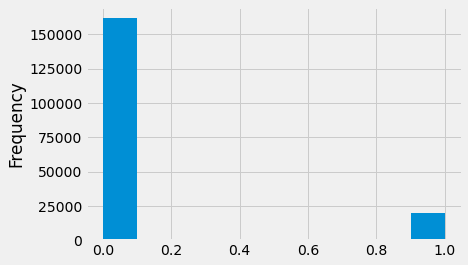

In [8]:
print(jobs['remote'].value_counts(normalize=True))
jobs['remote'].plot.hist();

0    0.859719
1    0.140281
Name: remote, dtype: float64


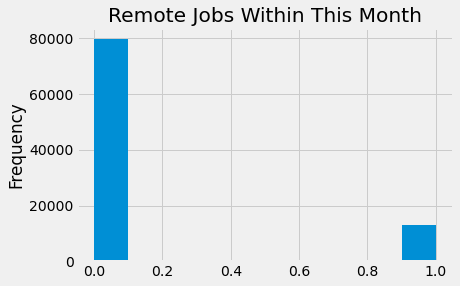

In [9]:
recent_jobs = jobs[jobs['job_post_age'] < 30]
print(recent_jobs['remote'].value_counts(normalize=True))
recent_jobs['remote'].plot.hist(title="Remote Jobs Within This Month");

What about jobs within a week of collection?

0    0.85359
1    0.14641
Name: remote, dtype: float64


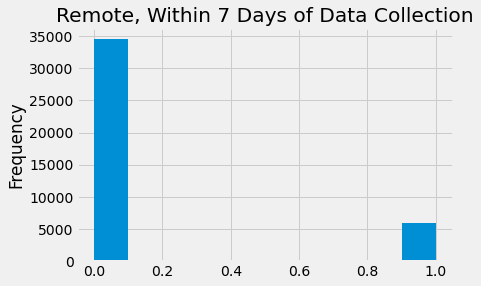

In [10]:
recent_week = jobs[jobs['job_post_age'] <= 7]
print(recent_week['remote'].value_counts(normalize=True))
recent_week['remote'].plot.hist(title="Remote, Within 7 Days of Data Collection");

Roughly the same proportion of job opportunities are marked as remote on Indeed as I progressed from looking at all jobs to jobs posted within a week of data collection. It looks like remote jobs are either still not the norm, or it is not typical yet for a job on indeed to explicitly label itself as a remote possibility. Also, since it's the first time I've looked at this data, I have no means of gauging the change from not-remote to remote job opportunities.

### Pay Range Columns
It would be ideal to create pay range columns for the individual pay ranges ('an hour', 'a month', 'a year'. excluding the smallest groups) in order to create two standardized yearly pay columns like so:

|pay_floor|pay_ceiling|
|---------|-----------|
|50000    |90000      |
|75000    |125345     |

In [11]:
jobs['pay'] = jobs['pay'].fillna('N/A')
jobs.head()

,role,company,location,pay,remote,details,job_post_age,search_field
0,Lead Software Engineer - eCommerce,COVETRUS INC,"Birmingham, AL 35203",N/A,0,"Our advanced web tools, client marketing progr...",30,Marketing Technologist
1,Associate Director of UAA Student Web Experience,University of Alaska,"Anchorage, AK 99508 (Rogers Park area)",N/A,0,Produces clear documentation for marketing pag...,30,Marketing Technologist
2,"Sales Support, Coronary Clinical Specialist - ...",Philips,"Tucson, AZ",N/A,0,Supports marketing related trade shows and ven...,7,Marketing Technologist
3,Laboratory Operations Manager,Lighthouse Lab Services,"Phoenix, AZ 85016 (Camelback East area)",N/A,0,Work with hospital strategy department and mar...,13,Marketing Technologist
4,Snr Key Account Technology Engineer I - EPI,ASM,"Phoenix, AZ",N/A,0,Related work experience can include process en...,30,Marketing Technologist


In [12]:
jobs['pay'] = jobs['pay'].str.replace('$', '')
jobs['pay'] = jobs['pay'].str.replace(',', '')

In order to convert the ranges to floor and ceiling, i need to find out how many different categories of pay range there is (i.e. "a year", "a week", "an hour", etc...)

In [13]:
jobs[jobs['pay'].str.contains('\d+\s\-\s\d+\s(a|an)\s+.*')]['pay'].str.replace('[^a-zA-z]', '').value_counts()

/home/jose/miniconda3/envs/data-gov/lib/python3.7/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


ayear     12675
anhour     5545
amonth      743
aweek        51
aday         22
Name: pay, dtype: int64

For practicality's sake, I'll only convert ranges with "a year", "a month", or "an hour".

In [14]:
jobs['yearly'] = jobs['pay']

# convert anything in the yearly column that isnt yearly to 'N/A'
jobs.loc[~jobs['yearly'].str.contains('a year'), 'yearly'] = 'N/A' 

# remove 'a year' from yearly column
jobs['yearly'] = jobs['yearly'].str.replace('[^0-9\-]', '')

# create floor pay column
jobs['floor_pay_yearly'] = jobs['yearly'].str.replace('\-\d+', '')
jobs.loc[jobs['floor_pay_yearly'] == '', 'floor_pay_yearly'] = np.nan
jobs['floor_pay_yearly'] = jobs['floor_pay_yearly'].astype(float)

# create ceiling pay column
jobs['ceiling_pay_yearly'] = jobs['yearly'].str.replace('\d+\-', '')
jobs.loc[jobs['ceiling_pay_yearly'] == '', 'ceiling_pay_yearly'] = np.nan
jobs['ceiling_pay_yearly'] = jobs['ceiling_pay_yearly'].astype(float)

In [15]:
# repeat the process with monthly pay ranges
jobs['monthly'] = jobs['pay']

# anything in the new column that isn't part of the category becomes 'N/A'
jobs.loc[~jobs['monthly'].str.contains('a month'), 'monthly'] = 'N/A'

# remove 'a month' from column
jobs['monthly'] = jobs['monthly'].str.replace('[^0-9\-]', '')
jobs.loc[jobs['monthly'] == '', 'monthly'] = np.nan

# insert floor and ceiling into the corresponding yearly column
jobs.loc[jobs['monthly'].notnull(), 'floor_pay_yearly'] = (jobs['monthly']
                                                       .str.replace('\-\d+', '')
                                                       .astype(float) * 12)
jobs.loc[jobs['monthly'].notnull(), 'ceiling_pay_yearly'] = (jobs['monthly']
                                                            .str.replace('\d+\-', '')
                                                            .astype(float) * 12)

Here, I'm multiplying hourly rates by 2 and then by 1000. This is operating under the rough assumption that if a person makes 70,000 dollars a year, they are working 40 hours a week for ~52 weeks out of the year:

$(\$35\ per\ hour) \times (40\ hours\ per\ week) \times (52\ weeks) \approx \$70,000\ a\ year$

In [16]:
# repeat the process with hourly pay ranges
jobs['hourly'] = jobs['pay']

# anything in the new column that isn't part of the category becomes 'N/A'
jobs.loc[~jobs['hourly'].str.contains('an hour'), 'hourly'] = 'N/A'

# remove 'an hour' from new column
jobs['hourly'] = jobs['hourly'].str.replace('[^0-9\-\.]', '')
jobs.loc[jobs['hourly'] == '', 'hourly'] = np.nan

# insert floor and ceiling into the corresponding yearly column
jobs.loc[jobs['hourly'].notnull(), 'floor_pay_yearly'] = ((jobs['hourly']
                                                       .str.replace('\-\d+\.*\d*', '')
                                                       .astype(float) * 2) * 1000)
jobs.loc[jobs['hourly'].notnull(), 'ceiling_pay_yearly'] = ((jobs['hourly']
                                                            .str.replace('\d+\.*\d*\-', '')
                                                            .astype(float) * 2) * 1000)

In [17]:
print(f"Average Pay Floor: ${round(jobs['floor_pay_yearly'].mean(), 2)}")
print(f"Average Pay Ceiling: ${round(jobs['ceiling_pay_yearly'].mean(), 2)}")

Average Pay Floor: $64984.29
Average Pay Ceiling: $82665.46


Before moving on, I'd like to make sure there aren't any obvious outliers/potential mistakes

In [18]:
jobs['floor_pay_yearly'].describe()

count     25601.000000
mean      64984.293153
std       34347.985919
min        9600.000000
25%       40000.000000
50%       58200.000000
75%       84360.000000
max      500000.000000
Name: floor_pay_yearly, dtype: float64

A max yearly pay of 500k sounds like a mistake or influence from outliers, and so does a minimum of 9600 a year. I'll consider anything over 200k or under 30k suspect.

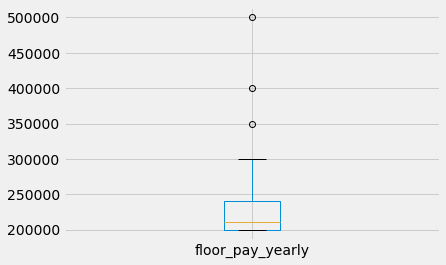

In [19]:
jobs[['floor_pay_yearly']][jobs['floor_pay_yearly'] >= 200000].plot.box();

In [20]:
jobs[['role', 'pay', 'details', 'floor_pay_yearly']][jobs['floor_pay_yearly'] >= 200000][100:150]

,role,pay,details,floor_pay_yearly
218496,"Senior Customer Onboarding Manager, Enterprise",From 250000 a year,Manage both technical and relationship escalat...,250000.0
220292,Sales Representative / Key Account Manager,From 200000 a year,Our target candidates will have previous exper...,200000.0
228418,Physician (Critical Care Noctensivist),300000 - 330000 a year,Background checks and security clearance.Subje...,300000.0
232511,Physician - Community Living Center,210000 - 243000 a year,Background checks and security clearance.Subje...,210000.0
232704,Physician (Neurologist),200000 - 225000 a year,Background checks and security clearance.Subje...,200000.0
235319,Physician (Endocrinology),230000 - 260000 a year,Background checks and security clearance.Subje...,230000.0
241155,Staff Diagnostic Radiologist,300000 - 400000 a year,Background checks and security clearance.Subje...,300000.0
241419,Physician (Emergency Medicine),250000 - 348000 a year,Background checks and security clearance.Subje...,250000.0


Upon closer inspection, it seems that some medical industry jobs sneaked into the search. Although they aren't many, they don't fit into the analysis and some of them are paid well enough to be outliers. Some are also sales jobs which do not apply.They will be removed.

In [21]:
jobs = jobs.drop(jobs[jobs['role']
                 .str.contains(
                     'Physician|Radiologist|Psychiatrist|Medical Director|Sales[^Salesforce]'
                 )].index)

In [22]:
jobs[jobs['floor_pay_yearly'] >= 300000]

,role,company,location,pay,remote,details,job_post_age,search_field,yearly,floor_pay_yearly,ceiling_pay_yearly,monthly,hourly
19916,Call For Virtual Workshop Presenters (Healthy ...,Ten Spot,"New York, NY 10001 (Chelsea area)",150 - 200 an hour,1,We are seeking Live Virtual Workshop Presenter...,20,Content Manager,,300000.0,400000.0,NaN,150-200
19999,Chief Marketing Officer,Access Staffing LLC,"New York, NY 10017 (Murray Hill area)",350000 - 500000 a year,0,Execute and assess integrated multi- channel d...,30,Content Manager,350000-500000,350000.0,500000.0,NaN,NaN
20016,Global Product Management Leader | eCommerce,Glocomms,"New York, NY",300000 a year,0,"Collaborate with Product Management, Engineeri...",21,Content Manager,300000,300000.0,300000.0,NaN,NaN
185324,"Director, Account Strategy & Corporate Develop...",Boys & Girls Clubs of America,"Atlanta, GA 30309 (Midtown area)",500000 a year,0,Primary lead and contributor to the strategy d...,30,Technical Lead,500000,500000.0,500000.0,NaN,NaN
193773,Project Manager - Potable - Private,HR Green,"Saint Paul, MN 55114 (St. Anthony area)",300000 a year,0,Assists with pre-positioning strategies; ident...,30,Technical Lead,300000,300000.0,300000.0,NaN,NaN


The jobs with \$500000 per year pay ceilings will be removed, as they are pretty extreme outliers

In [23]:
jobs = jobs.drop([19999, 185324])

In [24]:
jobs['floor_pay_yearly'].describe()

count     24817.000000
mean      65188.150824
std       33842.957087
min        9600.000000
25%       40000.000000
50%       59004.000000
75%       85000.000000
max      300000.000000
Name: floor_pay_yearly, dtype: float64

The lower range of pay is a minimum of 9600 a year, this still seems strange. Jobs with a salary less than 20000 will be dropped

In [25]:
jobs = jobs.drop(jobs[jobs['floor_pay_yearly'] < 20000].index)

65847.06718947842


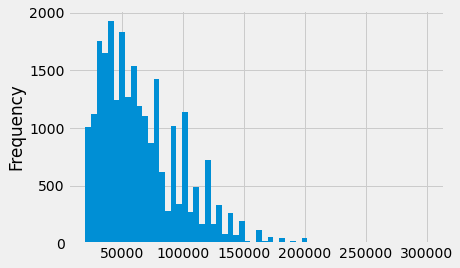

In [26]:
print(jobs['floor_pay_yearly'].mean())
jobs['floor_pay_yearly'].plot.hist(bins=60);

83433.16713638035


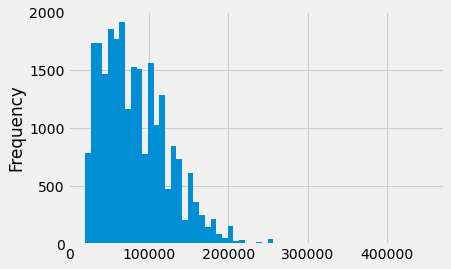

In [27]:
print(jobs['ceiling_pay_yearly'].mean())
jobs['ceiling_pay_yearly'].plot.hist(bins=60);

Since the distributions are right skewed with a somewhat large scale, log transformation can be used to get a more accurate representation of the mean pay floor and ceiling

/home/jose/miniconda3/envs/data-gov/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/jose/miniconda3/envs/data-gov/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


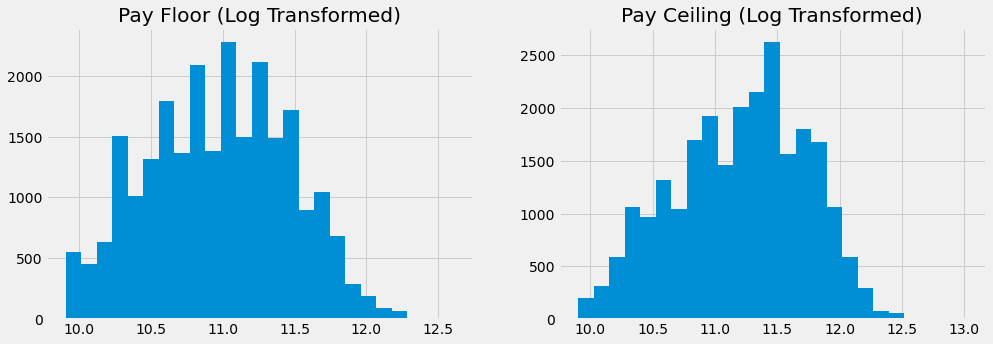

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
n_bins = 25
floor = np.log1p(jobs['floor_pay_yearly'])
ceiling = np.log1p(jobs['ceiling_pay_yearly'])
axes[0].hist(floor, bins=n_bins)
axes[1].hist(ceiling, bins=n_bins)
axes[0].set_title('Pay Floor (Log Transformed)')
axes[1].set_title('Pay Ceiling (Log Transformed)')

for ax in axes:
    ax.grid(True)

plt.show()

In [29]:
print(f"Average Pay Floor (Log Transformed): ${np.expm1(floor.mean())}")
print(f"Average Pay Ceiling (Log Transformed): ${np.expm1(ceiling.mean())}")

Average Pay Floor (Log Transformed): $58167.110664481224
Average Pay Ceiling (Log Transformed): $73025.25260212176


### Individual Jobs
To answer the question of which jobs have more remote possibilities I'll take a look at the top 20 jobs. This will also help answer the question of average pay range per job. There is one issue, however: The `search_field` result column does not ensure that its value will be related to the `role` column. The job roles have a lot of variation in how they're named, and picking out groups manually would be an impractical waste of time. 

The proposed method to alleviate this is to take a deterministic and a probabilistic model and use the text details of the job to classify the roles that are named with enough variation to make them appear to be different jobs. Here I will use a Multinomial Naive Bayes and a K-Nearest Neighbors to see which gets better accuracy. The winner will classify the job roles in a new column. Similarity score will also be stored. Scores below a threshold will be discarded. 

In [30]:
# First, some housekeeping: The software developer role and it's
# corresponding search field have a spelling discrepancy
jobs.loc[jobs['search_field'] == 'Software Developers', 'search_field'] = "Software Developer"

In [31]:
# Now, the jobs where the role and search_field align exactly
# will become the training data. This could be difficult to test
# because some roles only have one example
class_data = jobs[jobs['role'] == jobs['search_field']]

In [32]:
class_data[class_data['role'] == "SEO Consultant"]

,role,company,location,pay,remote,details,job_post_age,search_field,yearly,floor_pay_yearly,ceiling_pay_yearly,monthly,hourly
846,SEO Consultant,Noxster,"Culver City, CA",N/A,0,Education Minimum: Bachelor’s degree prefered....,30,SEO Consultant,,NaN,NaN,NaN,NaN


Because some of the roles only have one example, I'll manually choose some of the search results that align with the `search_field` job title to rename according to the target job roles. This will make it easier to create a stratified train/test split

In [33]:
class_data['role'].value_counts()[class_data['role'].value_counts() == 1]

Mobile App Developer       1
Web Analytics Developer    1
Front-End Designer         1
SEO Consultant             1
Name: role, dtype: int64

In [34]:
# create a new column that will be used as the new label
jobs['job_label'] = jobs['role']

In [35]:
seo_data = jobs[jobs['search_field'] == 'SEO Consultant'][['role', 'details']].values
seo_index = jobs[jobs['search_field'] == 'SEO Consultant'][['role', 'details']].index

weban_data = jobs[jobs['search_field'] == 'Web Analytics Developer'][['role', 'details']].values
weban_index = jobs[jobs['search_field'] == 'Web Analytics Developer'][['role', 'details']].index

fedes_data = jobs[jobs['search_field'] == 'Front-End Designer'][['role', 'details']].values
fedes_index = jobs[jobs['search_field'] == 'Front-End Designer'][['role', 'details']].index

mobapp_data = jobs[jobs['search_field'] == 'Mobile App Developer'][['role', 'details']].values
mobapp_index = jobs[jobs['search_field'] == 'Mobile App Developer'][['role', 'details']].index

seo = list(zip(seo_data, seo_index))
weban = list(zip(weban_data, weban_index))
fedes = list(zip(fedes_data, fedes_index))
mobapp = list(zip(mobapp_data, mobapp_index))

In [36]:
# create a dictionary to hold the indices of good matches for named roles
job_label_dict = {'SEO Consultant':[848, 905, 1168],
                  'Web Analytics Developer': [1175, 1187, 1186],
                  'Front-End Designer': [45382, 45417, 45424],
                  'Mobile App Developer': [245883, 245957, 246029]}

In [ ]:
for value, index in mobapp:
    print(value[1], index, value[0])
    print(">>>>>>>>>>>>>>>>>>>>>>")

In [37]:
for job_name, indices in job_label_dict.items():
    for idx in indices:
        jobs.loc[idx, 'job_label'] = job_name

Now there should be enough data to split into train and test

In [38]:
class_data = jobs[jobs['job_label'] == jobs['search_field']][['job_label', 'details']]
class_data['job_label'].value_counts()

Systems Engineer             559
Product Manager              500
Software Developer           472
Data Scientist               438
Data Analyst                 328
Database Administrator       251
Systems Administrator        235
Digital Marketing Manager    228
Business Systems Analyst     180
UX Designer                  115
Data Architect                88
Technical Account Manager     88
Security Specialist           74
Technical Lead                62
Python Developer              45
Social Media Manager          42
Mobile Developer              36
Cloud Architect               36
Content Strategist            33
Front-End Developer           28
Content Manager               26
UI Designer                   21
Agile Project Manager         21
Data Modeler                  17
Ruby on Rails Developer       13
WordPress Developer            9
Growth Hacker                  9
DevOps Manager                 9
Full-Stack Developer           7
Interaction Designer           5
Accessibil

#### Creating Training Data
Now the details from each job in the new training data need to be vectorized.

In [39]:
class_data.head()

,job_label,details
20,Marketing Technologist,"Develop, support, and maintain integrations am..."
230,Marketing Technologist,B2C marketing: 2 years (Preferred).Your experi...
351,Marketing Technologist,Solid business acumen to understand marketing ...
354,Marketing Technologist,"Develop, support, and maintain integrations am..."
846,SEO Consultant,Education Minimum: Bachelor’s degree prefered....


In [40]:
# accuracy in predictions may increase if the job_label is adds to the description
class_data['details'] = class_data['job_label'] + ' ' + class_data['details'] 

In [41]:
def format_text(series, inplace=False):
    """Format text in a way that optimizes vectorization"""
    if not inplace:
        series = series.copy()
    series = series.str.replace('[^a-zA-Z0-9]', ' ')
    series = series.str.replace('\s{2}', ' ')
    series = series.str.lower().str.strip()
    
    return series

In [42]:
documents = format_text(class_data['details'])

In [43]:
documents.iloc[3999]

'security specialist follow all security and emergency procedures 2 years experience working in security must pass background check no felony convictions of any kind per state'

In [44]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                             max_df=.80, min_df=10)
le = LabelEncoder()
le.fit(class_data['job_label'])

X = vectorizer.fit_transform(documents)
y = le.transform(class_data['job_label'])

In [45]:
print(X.shape)
print(y.shape)

(4004, 2069)
(4004,)


In [46]:
# split X into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(3203, 2069) (801, 2069)
(3203,) (801,)


In [49]:
neighbors = KNeighborsClassifier(algorithm="brute", metric="cosine")
neighbors.fit(X_train, y_train)

n_bayes = MultinomialNB(alpha=0.1)
n_bayes.fit(X_train, y_train)

y_pred_neighbors = neighbors.predict(X_test)
y_pred_n_bayes = n_bayes.predict(X_test)
print(f"KNeighbors: {accuracy_score(y_test, y_pred_neighbors)}")
print(f"MultinomialNB: {accuracy_score(y_test, y_pred_n_bayes)}")

KNeighbors: 0.9138576779026217
MultinomialNB: 0.9225967540574282


In [50]:
jobs['role_plus_details'] = jobs['role'] + ' ' + jobs['details']
jobs['role_plus_details'] = format_text(jobs['role_plus_details'])
jobs[['role', 'search_field', 'role_plus_details']]

,role,search_field,role_plus_details
0,Lead Software Engineer - eCommerce,Marketing Technologist,lead software engineer ecommerce our advanced...
1,Associate Director of UAA Student Web Experience,Marketing Technologist,associate director of uaa student web experien...
3,Laboratory Operations Manager,Marketing Technologist,laboratory operations manager work with hospit...
4,Snr Key Account Technology Engineer I - EPI,Marketing Technologist,snr key account technology engineer i epi rel...
5,Sleep Lab Manager,Marketing Technologist,sleep lab manager current state respiratory th...
...,...,...,...
247959,Mobile Automation Tester,Mobile App Developer,mobile automation tester 4 years of experience...
247964,Principal Software Engineer (Coupang Ads),Mobile App Developer,principal software engineer coupang ads this i...
247965,Application/API Developer (IT App Dev -SR/SP) ...,Mobile App Developer,application api developer it app dev sr sp non...
247966,"Sr. Technical Program Manager, Alexa Communica...",Mobile App Developer,sr technical program manager alexa communicati...


In [51]:
desc = jobs['role_plus_details'].iloc[23094]
print(desc)
desc = vectorizer.transform([desc])
le.inverse_transform(n_bayes.predict(desc))

interaction designer collaborate with visual designers content strategists and engineering teams to implement your designs 6  12 months contract possible extension


array(['UX Designer'], dtype=object)

In [52]:
descriptions = jobs['role_plus_details']
descriptions = vectorizer.transform(descriptions)
descriptions = n_bayes.predict(descriptions)
jobs['predicted_role'] = le.inverse_transform(descriptions)

In [53]:
jobs.loc[(jobs['predicted_role'] == 'Security Specialist')][['role', 'search_field', 'predicted_role', 'details']]

,role,search_field,predicted_role,details
46,Sr. Order Processing Specialist,Marketing Technologist,Security Specialist,Prepare and approve documents for engineer or ...
227,Certified Medical Assistant,Marketing Technologist,Security Specialist,Collaborates with office staff on marketing ef...
419,Medical Front Desk Receptionist,Marketing Technologist,Security Specialist,Employee is responsible for checking in patien...
675,Clinical Nurse Specialist,Marketing Technologist,Security Specialist,Accountability Objective: *MRI Nurse Clinical ...
848,SEO Specialist,SEO Consultant,Security Specialist,3-6 years working as an SEO or related type of...
...,...,...,...,...
243255,"Medical Laboratory Specialist, Days - Point of...",QA Quality Assurance Specialist,Security Specialist,Provides computer support for changing test ta...
243413,Regulatory Specialist,QA Quality Assurance Specialist,Security Specialist,2-4 years of regulatory and quality experience...
243641,"Construction Specialist - Livermore, CA",Game Developer,Security Specialist,"Attend meetings with builders, developers and ..."
244249,Multi-Media Specialist MMS-S2025,Game Developer,Security Specialist,"The Multi-Media Specialist, with guidance from..."


In [56]:
# top ten before label prediction
for rank, role in enumerate(jobs['role'].value_counts()[:10].index):
    print(f"{rank+1}. {role}")

1. Software Engineer
2. Senior Software Engineer
3. Software Developer
4. Business Analyst
5. Product Manager
6. Systems Engineer
7. Project Manager
8. Data Analyst
9. Systems Administrator
10. Data Scientist


In [57]:
# top ten after label prediction
for rank, role in enumerate(jobs['predicted_role'].value_counts()[:10].index):
    print(f"{rank+1}. {role}")

1. Systems Engineer
2. Software Developer
3. Product Manager
4. Data Analyst
5. Data Scientist
6. Business Systems Analyst
7. Digital Marketing Manager
8. Systems Administrator
9. Technical Account Manager
10. Security Specialist


Problem solved? Not quite. It's possible that a good deal of jobs are still incorrectly categorized, simply on account of non-tech jobs still existing within the data. A potential (tedious) remedy for this may be to manually restrict the jobs that are allowed to exist in the data in the first place by looking at top roles and removing non-tech jobs, keeping only the most prominent positions. Although this would remove a great deal of data, it could be a potential solution, allowing at the very least for a sample analysis.

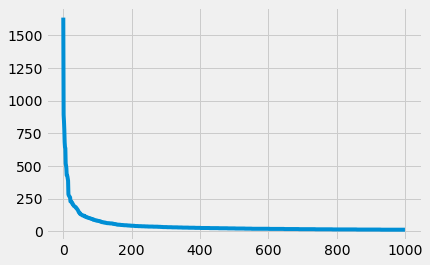

In [93]:
counts = jobs['role'].value_counts()[:1000].values
plt.plot(counts)